In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits import mplot3d
from matplotlib import rcParams
import matplotlib.colors as colors
import copy
import math
import sys
sys.setrecursionlimit(2000)

In [2]:
# 2-dimensional lens and optical system class
#    It is assumed that the ray travels in the +x-direction, 
#    that is theta < pi/2 where theta=\atan(gamma_y/gamma_x)

#########################################################################################################################
############################################## Function: quadraticEquation ##############################################
#########################################################################################################################
def quadraticEquation(sign, c_1, c_2, c_3, verbos=False):
    num = c_2**2 - 4*c_1*c_3
    if num < 0:
        if verbos:
            print('WARNING: num cannot be < 0')
        return 'error'
    return ( -c_2 + sign*num**(1/2) ) / (2*c_1)

##################################################################################################################
############################################## Function: limitTheta ##############################################
##################################################################################################################
def limitTheta(theta, lower=0, upper=2*math.pi, verbos=False):
    if lower >= upper:
        raise ValueError("upper must be > than lower")
        
    while theta < lower:
        theta = theta + 2*math.pi
    while theta > upper:
        theta = theta - 2*math.pi
        
    return theta

############################################################################################################
############################################## Class: surface ##############################################
############################################################################################################
class surface:
    def __init__(self,surface):
        self.r_x     = surface.r_x
        self.r_y     = surface.r_y
        self.x       = surface.x
        self.verbose = surface.verbose
        
    def __init__(self,r_x,r_y,x,verbose=False):
        if r_x == 0 or r_y == 0:
            raise ValueError("Radius cannot be 0")
        self.r_x     = r_x
        self.r_y     = r_y
        self.x       = x
        self.verbose = verbose
    
    def get_points(self,nPoints,safty=1e-10):
        sign = 0
        if self.r_x < 0:
            sign = -1
        else:
            sign = +1
        lim = [self.x+sign*safty,self.x+self.r_x-sign*safty]
            
        points = []
        for x in np.linspace(lim[0],lim[1],nPoints):
            y = (self.r_y**2 + self.r_y**2/self.r_x**2*(-x**2+2*x*self.x-self.x**2))**(1/2)
            points.append((x,y))
        for x in np.linspace(lim[1],lim[0],nPoints):
            y = (self.r_y**2 + self.r_y**2/self.r_x**2*(-x**2+2*x*self.x-self.x**2))**(1/2)
            points.append((x,-y))
            
        return points
    
    def get_maxTheta(self,opticalRay):
        bounds = []
        
        deltaX = self.x - opticalRay.x
        if deltaX < 0:
            raise ValueError("Optical ray must has x<x_l")
            
        deltaY = self.r_y - opticalRay.y
        bounds.append(math.atan(deltaY/deltaX))
                      
        deltaY = -self.r_y - opticalRay.y
        bounds.append(math.atan(deltaY/deltaX))
        
        return bounds
        
class lens:
    def __init__(self,lens):
        self.surface_1 = lens.surface_1
        self.surface_2 = lens.surface_2
        self.refInd    = lens.refInd
        self.verbose   = lens.verbose
        self.__sortSurfaces()
        
    def __init__(self,surface_1,surface_2,refInd,verbose=False):
        self.surface_1 = surface_1
        self.surface_2 = surface_2
        self.refInd    = refInd
        self.verbose   = verbose
        self.__sortSurfaces()
        
    def __sortSurfaces(self):
        if self.surface_1.x + self.surface_1.r_x > self.surface_2.x + self.surface_2.r_x:
            self.surface_1, self.surface_2 = self.surface_2, self.surface_1
    
    def get_points(self,nPoints):
        return self.surface_1.get_points(nPoints), self.surface_2.get_points(nPoints)
            
##################################################################################################################
############################################## Class: opticalSystem ##############################################
##################################################################################################################
class opticalSystem:
    def __init__(self,lenses,finalSurface,refInd,verbose=False):
        self.lenses       = lenses
        self.finalSurface = finalSurface
        self.verbose      = verbose
        self.__sort_lenses()
        self.__check_lensOverlap()
        self.__check_finalSurface()
        self.surfaces = []
        for lens in lenses:
            self.surfaces.append(lens.surface_1)
            self.surfaces.append(lens.surface_2)
        self.surfaces.append(self.finalSurface)
        self.__check_surfaces_length()
        
        self.refIndices = [refInd]
        for lens in lenses:
            self.refIndices.append(lens.refInd)
            self.refIndices.append(refInd)
    
    def add_lens(self,lens):
        self.lenses.append(lens)
        self.__sortLenses()
        self.__check_lensOverlap()
        self.__check_finalSurface()
        self.__check_surfaces_length()
        self.__update_surfaces_order(lens)
    
    def __sort_lenses(self):
        self.lenses.sort(key=lambda lens: lens.surface_1.x + lens.surface_1.r_x)
        
    def __check_lensOverlap(self):
        for i in range(len(self.lenses) - 1):
            lens_1 = self.lenses[i]
            lens_2 = self.lenses[i + 1]
            surface_1 = lens_1.surface_2
            surface_2 = lens_2.surface_1
            if surface_1.x + surface_1.r_x > surface_2.x + surface_2.r_x:
                raise ValueError("Lens overlap detected")
        return True
    
    def __check_finalSurface(self):
        lastLensSurface = self.lenses[-1].surface_2.r_x + self.lenses[-1].surface_2.x
        if lastLensSurface > self.finalSurface.r_x + self.finalSurface.x:
            raise ValueError("Final surface does not have greatest radius+x")
        return True
    
    def __update_surfaces_order(self,lens):
        # O(N) (linear) implementation
        # could use bisection to make faster for large N
        for surface in self.surfaces:
            if surface.r_x + surface.x > lens.surface_1.r_x + lens.surface_2.x:
                self.surfaces.append(lens_surface_1)
                self.surfaces.append(lens_surface_2)
                break
                
    def __check_surfaces_length(self):
        if len(self.surfaces) == 0:
            raise ValueError("Surfaces cannot be empty")
            
    def get_points(self,nPoints):
        points = []
        for surface in self.surfaces:
            points.append(surface.get_points(nPoints))
            
        return points

###############################################################################################################
############################################## Class: opticalRay ##############################################
###############################################################################################################
class opticalRay:
    def __init__(self,opticalRay):
        self.x       = opticalRay.x
        self.y       = opticalRay.y
        self.theta   = opticalRay.theta
        self.verbose = opticalRay.verbose
        self.__checkTheta()
        
    def __init__(self,x,y,theta,verbose=False):
        self.x       = x
        self.y       = y
        self.theta   = theta
        self.verbose = verbose
        self.__checkTheta()
    
    def update_theta(self,theta):
        self.theta = theta
        return self.__checkTheta()
    
    def __checkTheta(self):
        self.theta = limitTheta(self.theta,self.verbose)
            
        # if self.theta >= math.pi/2 and self.theta <= 3/2*math.pi:
        if math.cos(self.theta) <= 0:
            raise ValueError("Theta out of bounds")
            
        return True
    
##################################################################################################################
############################################## Class: rayPropagator ##############################################
##################################################################################################################
class rayPropagator:
    def __init__(self,opticalSystem,opticalRay,verbose=False):
        self.opticalSystem = opticalSystem
        self.opticalRay    = opticalRay
        self.verbose = verbose
        if self.opticalRay.x > self.opticalSystem.surfaces[0].r_x + self.opticalSystem.surfaces[0].x:
            raise ValueError("x-position of optical ray is not less than all lenses' x-positions")
        
    def propagateRay(self,nSurfacesPropagate=-1):
        opticalRay_temp = copy.deepcopy(self.opticalRay)
        steps = [copy.deepcopy(opticalRay_temp)]
            
        if nSurfacesPropagate > len(self.opticalSystem.surfaces): 
            nSurfacesPropagate = -1
            
        self.__translateRay(self.opticalSystem.surfaces[0],opticalRay_temp)
        steps.append(copy.deepcopy(opticalRay_temp))
        for nSurface in range(0,len(self.opticalSystem.surfaces)-1):
            if nSurfacesPropagate>0 and nSurface+1 > nSurfacesPropagate:
                break
                
            if opticalRay_temp.theta >= 0:
                opticalRay_temp = self.__refractRay(self.opticalSystem.surfaces[nSurface],opticalRay_temp,self.opticalSystem.refIndices[nSurface],self.opticalSystem.refIndices[nSurface+1])
            if opticalRay_temp.theta >= 0:
                opticalRay_temp = self.__translateRay(self.opticalSystem.surfaces[nSurface+1],opticalRay_temp)
                
            steps.append(copy.deepcopy(opticalRay_temp))
        
        return steps
    
    def __translateRay(self,surface,opticalRay_temp):
        if surface.r_x > 0: sign = +1
        if surface.r_x < 0: sign = -1
        
        m = math.tan(opticalRay_temp.theta)
        c_1 = 1/surface.r_x**2 + m**2/surface.r_y**2
        c_2 = -2*surface.x/surface.r_x**2 + m/surface.r_y**2 * (-2*m*opticalRay_temp.x + 2*opticalRay_temp.y)
        c_3 = surface.x**2/surface.r_x**2 + ((m*opticalRay_temp.x - opticalRay_temp.y)/surface.r_y)**2 - 1
        
        x_original = opticalRay_temp.x
        num = quadraticEquation(sign,c_1,c_2,c_3,self.verbose)
        if num == 'error':
            if self.verbose:
                print('WARNING: ray translated to invalid point')
            opticalRay_temp.theta = -99999
        else:
            opticalRay_temp.x = num
            opticalRay_temp.y = m * (opticalRay_temp.x - x_original) + opticalRay_temp.y
        
        # print('x',opticalRay_temp.x)
        # print('y',opticalRay_temp.y)
        
        return opticalRay_temp
    
    def __refractRay(self,surface,opticalRay_temp,refInd_i,refInd_f):
        num = surface.r_y**2/surface.r_x**2*(-opticalRay_temp.x**2+2*surface.x*opticalRay_temp.x-surface.x**2)+surface.r_y**2
        if num <  0: 
            if self.verbose: print('WARNING: num<0:',num)
            num = 0
        if num == 0: 
            if self.verbose: print('WARNING: num==0:',num)
            num = 1e-25
        dydx = surface.r_y**2/surface.r_x**2*(surface.x-opticalRay_temp.x)*num**(-1/2)
        print('y',opticalRay_temp.y)
        if opticalRay_temp.y < 0: dydx = -dydx
        theta_n = math.atan(-1/dydx)
        
        theta_in = limitTheta(opticalRay_temp.theta)-limitTheta(theta_n)
        print('theta_i',limitTheta(opticalRay_temp.theta))
        print('theta_n',limitTheta(theta_n))
        print('theta_in',theta_in/math.pi*180)
        theta_in_sign = theta_in/abs(theta_in)
        if abs(theta_in) > math.pi: theta_in = abs(abs(theta_in)-2*math.pi)
        else                      : theta_in = abs(theta_in)
        
        if refInd_f <= refInd_i:
            theta_c = math.asin(refInd_f/refInd_i)
            if theta_in >= theta_c:
                if self.verbose:
                    print('WARNING: total internal reflection')
                opticalRay_temp.theta = -99999
                # print('!!!!!!!!!!!FAILED!!!!!!!!!!')
                # print('dydx',dydx)
                # print('-dxdy',-1/dydx)
                # print('theta_n',theta_n/math.pi*180)
                # print('theta_i',opticalRay_temp.theta/math.pi*180)
                # print('theta_in',theta_in/math.pi*180)
                # print('**************************************')
                return opticalRay_temp
        
        num2 = refInd_i/refInd_f*math.sin(theta_in)
        if abs(num2)>1: 
            raise ValueError('WARNING: total internal reflection, |num2|>1:')
        
        theta_o = math.asin(num2)
        theta_f = theta_n-theta_in_sign*theta_o
        
        print('dydx',dydx)
        print('-dxdy',-1/dydx)
        print('theta_n',theta_n/math.pi*180)
        print('theta_i',opticalRay_temp.theta/math.pi*180)
        print('theta_in',theta_in/math.pi*180)
        print('theta_o',theta_o/math.pi*180)
        print('theta_f',theta_f/math.pi*180)
        print('**************************************')
        
        opticalRay_temp.update_theta(theta_f)
        
        return opticalRay_temp
    

[0.09966865249116204, -0.09966865249116204, 100]
y 0.009801980198019832
theta_i 0.09966865249116204
theta_n 4.911726285366983
theta_in -275.71059313749794
dydx 0.20202020202017082
-dxdy -4.950000000000765
theta_n -78.57881372500245
theta_i 5.710593137499643
theta_in 84.28940686250209
theta_o 48.92202637447121
theta_f -29.656787350531225
**************************************
y 0.003299417340339737
theta_i 5.76557672234901
theta_n 0.33624185215144237
theta_in 311.0779736255293
dydx -2.8611151649772495
-dxdy 0.34951406788546785
theta_n 19.265239023939465
theta_i 330.34321264946874
theta_in 48.922026374470704
theta_o 84.28940686249761
theta_f -65.02416783855816
**************************************
y 0.009801980198019832
theta_i 0.09966865249116204
theta_n 4.911726285366983
theta_in -275.71059313749794
dydx 0.20202020202017082
-dxdy -4.950000000000765
theta_n -78.57881372500245
theta_i 5.710593137499643
theta_in 84.28940686250209
theta_o 48.92202637447121
theta_f -29.656787350531225
****

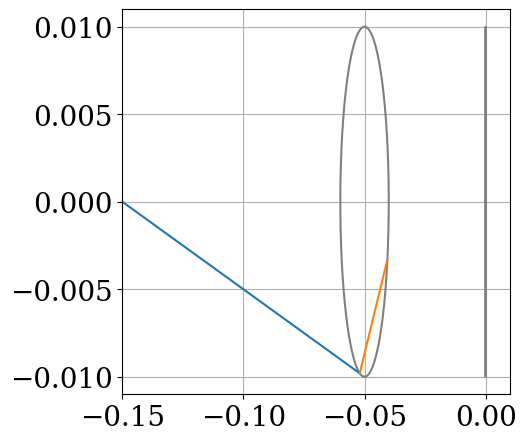

In [3]:
verbose = True
# surface_1_1_parameters = [-0.001,0.01,-0.05] # r_x, r_y, x
# surface_1_2_parameters = [ 0.001,0.01,-0.05] # r_x, r_y, x
surface_1_1_parameters = [-0.01,0.01,-0.05] # r_x, r_y, x
surface_1_2_parameters = [ 0.01,0.01,-0.05] # r_x, r_y, x
surface_f_parameters   = [ 1e-10,0.01, 0   ] # r_x, r_y, x
# x_lim                  = [ -5, L.surface_1.x + L.surface_1.r_x, 100 ] # min, max, nPoints
r = -0.15 # m
theta_lim              = [ -math.pi/10, math.pi/10, 100 ] # min, max, nPoints
phi_lim                = [ -math.pi/10, math.pi/10, 100 ] # min, max, nPoints
refInd_lens_1          = 1.98
refInd_medium          = 1.5
d                      = 1e-5 # step size

surface_1_1 = surface(surface_1_1_parameters[0],surface_1_1_parameters[1],surface_1_1_parameters[2],verbose)
surface_1_2 = surface(surface_1_2_parameters[0],surface_1_2_parameters[1],surface_1_2_parameters[2],verbose)
surface_f   = surface(surface_f_parameters  [0],surface_f_parameters  [1],surface_f_parameters  [2],verbose)
L = lens(surface_1_1,surface_1_2,refInd_lens_1,verbose)
OS = opticalSystem([L],surface_f,refInd_medium,verbose)

font = {'family' : 'serif', 'size' : 20 }
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'cm' # Set the math font to Computer Modern
mpl.rcParams['legend.fontsize'] = 1

fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(xmin=r,xmax=0.01)
ax.grid()

points_surfaces = OS.get_points(1000)
surface_1_1 = ax.plot([x for x,y in points_surfaces[0 ]], [y for x,y in points_surfaces[0 ]], color='gray')[0]
surface_1_2 = ax.plot([x for x,y in points_surfaces[1 ]], [y for x,y in points_surfaces[1 ]], color='gray')[0]
surface_f   = ax.plot([x for x,y in points_surfaces[-1]], [y for x,y in points_surfaces[-1]], color='gray')[0]
ray_i1 = ax.plot([],[])[0]
ray_12 = ax.plot([],[])[0]
ray_2f = ax.plot([],[])[0]
OR = opticalRay(r,0,0)
theta_lim[:2] = OS.surfaces[0].get_maxTheta(OR)
print(theta_lim)
def updateFrame(nFrame):
    # print('nFrame',nFrame)
    theta      = theta_lim[0] + ( theta_lim[1] - theta_lim[0] ) / (nFrames-1) * nFrame
    OR         = opticalRay(r,0,theta)
    # print('theta_i',OR.theta)
    RP         = rayPropagator(OS,OR)  
    points_ray = RP.propagateRay()
    points_ray_formatted = []
    for nPoint in range(len(points_ray)-1):
        points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
    
    ray_i1.set_data(points_ray_formatted[0][0], points_ray_formatted[0][1])
    ray_12.set_data(points_ray_formatted[1][0], points_ray_formatted[1][1])
    ray_2f.set_data(points_ray_formatted[2][0], points_ray_formatted[2][1])
    return surface_1_1, surface_1_2, surface_f, ray_i1, ray_12, ray_2f

nFrames = 10
animation = FuncAnimation(fig, updateFrame, frames=nFrames, interval=100, blit=True)
animation.save('test.gif', writer='pillow')
plt.show()

In [4]:
surface_1_1_parameters = [-0.01,0.01,-0.05] # r_x, r_y, x
surface_1_2_parameters = [ 0.01,0.01,-0.05] # r_x, r_y, x
surface_f_parameters   = [ 1e-10,0.01, 0  ] # r_x, r_y, x
# x_lim                  = [ -5, L.surface_1.x + L.surface_1.r_x, 100 ] # min, max, nPoints
r = -0.15 # m
theta_lim              = [ -math.pi/100, math.pi/100, 100 ] # min, max, nPoints
phi_lim                = [ -math.pi/100, math.pi/100, 100 ] # min, max, nPoints
refInd_lens_1          = 1.98
refInd_medium          = 1.5
d                      = 1e-5 # step size

surface_1_1 = surface(surface_1_1_parameters[0],surface_1_1_parameters[1],surface_1_1_parameters[2])
surface_1_2 = surface(surface_1_2_parameters[0],surface_1_2_parameters[1],surface_1_2_parameters[2])
surface_f   = surface(surface_f_parameters  [0],surface_f_parameters  [1],surface_f_parameters  [2])
L = lens(surface_1_1,surface_1_2,refInd_lens_1)
OS = opticalSystem([L],surface_f,refInd_medium)

points = []
for phi in np.linspace(phi_lim[0],phi_lim[1],phi_lim[2]):
    for theta in np.linspace(theta_lim[0],theta_lim[1],theta_lim[2]):
        print('theta',theta)
        OR         = opticalRay(r*math.cos(phi),r*math.sin(phi),theta)
        RP         = rayPropagator(OS,OR)
        points_ray = RP.propagateRay()
        point_i    = (points_ray[-1].x,points_ray[-1].y)
        if points_ray[-1].theta < -999:
            points.append((phi,theta,points_ray[-1].theta))
        else:
            OR         = opticalRay(r*math.cos(phi),r*math.sin(phi),theta+d)
            RP         = rayPropagator(OS,OR)
            points_ray = RP.propagateRay()
            point_f    = (points_ray[-1].x,points_ray[-1].y)
            if points_ray[-1].theta < -999:
                points.append((phi,theta,points_ray[-1].theta))
            else:
                dthetads = abs((point_f[1]-point_i[1])/d)
                print(dthetads)
                points.append((phi,theta,dthetads))
        
fig_1, ax_1 = plt.subplots(figsize=(5, 5))
cmap = plt.cm.jet
cmap.set_under('white')  # Set zero-valued bins to white
hist = ax_1.hist2d(
    [phi for phi,theta,deltatheta in points],
    [theta for phi,theta,deltatheta in points],
    bins=[phi_lim[2],theta_lim[2]],
    # cmap='rainbow',
    cmap=plt.cm.jet,
    weights=[deltatheta for phi,theta,deltatheta in points],
    # norm=colors.LogNorm(vmin=1),  # Set vmin directly in LogNorm
    vmin=0
)
ax_1.set_xlabel(r"$\phi$")
ax_1.set_ylabel(r"$\theta$")
# ax.set_xlim([0, 6])
# ax.set_ylim([0,math.pi/math.pi*180])
cbar = plt.colorbar(hist[3], ax=ax_1)
cbar.set_label(r'$d\theta/ds$')
# plt.savefig('A->ll Angle.pdf',bbox_inches='tight')

# Display the plot
plt.show()

theta -0.031415926535897934
y 0.001879972519278462
theta_i 6.2517693806436885
theta_n 6.094062666401115
theta_in 9.03592912697518
dydx 5.22438250646713
-dxdy -0.19141018077488114
theta_n -10.835929126975168
theta_i 358.2
theta_in 9.03592912697518
theta_o 6.833247690657001
theta_f -17.66917681763217
**************************************
y -0.004147317478897721
theta_i 5.974799995594851
theta_n 5.855537324788599
theta_in 6.833247690656352
dydx 2.1940536905523276
-dxdy -0.45577736055687024
theta_n -24.502424508288513
theta_i 342.3308231823678
theta_in 6.833247690656352
theta_o 9.03592912697432
theta_f -33.53835363526284
**************************************
theta -0.03078126135335454
y 0.001936873294039479
theta_i 6.252404045826232
theta_n 6.088266042223891
theta_in 9.404414864117241
dydx 5.065190960715842
-dxdy -0.19742592288340383
theta_n -11.168051227753564
theta_i 358.23636363636365
theta_in 9.404414864117241
theta_o 7.110849358440966
theta_f -18.27890058619453
*********************

ValueError: Theta out of bounds

In [ ]:
############################################################
### Determine mean distance needed to cross a square box ###
############################################################
d = 0.010/32 # <-- edge distance

nPoints_min =  2
nPoints_max = 10000
nPoints_delta = 100
list_nPoints = []
list_val = []

# Very computationally inefficient😊:
#   Should reuse previous smaller 
#   approximations so it would 
#   be O(N) and not ~O(N^2)
for nPoints in range(nPoints_min, nPoints_max, nPoints_delta):
  total = 0
  for nPoint in range(1,nPoints):
    p_1 = [np.random.uniform(0,d),0]
    p_2 = []
    temp = np.random.uniform(0,d*3)
    if temp <= d:
      p_2 = [0,temp]
    elif temp > d and temp <= d*2:
      p_2 = [temp,d]
    else:
      p_2 = [d,temp]
  
    total = total + ((p_1[0]-p_2[0])**2 + (p_1[1]-p_2[1])**2)**(1/2)
  list_nPoints.append(nPoints)
  list_val.append(total/nPoints)

font = {'family' : 'serif', 'size' : 20 }
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'cm' # Set the math font to Computer Modern
mpl.rcParams['legend.fontsize'] = 1
plt.figure(figsize=(5,1))
plt.plot(list_nPoints, list_val)
plt.ylim(0, 0.0006)
# plt.xlim(nPoints_max-nPoints_delta*10,nPoints_max)
plt.xlim(nPoints_min,nPoints_max)
# plt.savefig('meanDistance.pdf',bbox_inches='tight')
plt.show()

meanDist = list_val[-1]
print(meanDist)

In [ ]:
surface_1 = surface(1.5,1,1)        # r_x, r_y, x
surface_2 = surface(1,1,1)          # r_x, r_y, x
surface_f = surface(0.0001,1,4)     # r_x, r_y, x
L = lens(surface_1,surface_2,1)     # surface_1, surface_2, refInd
OS = opticalSystem([L],surface_f,1) # [lenses], finalSurface, refInd

font = {'family' : 'serif', 'size' : 20 }
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'cm' # Set the math font to Computer Modern
mpl.rcParams['legend.fontsize'] = 1

fig, ax = plt.subplots(figsize=(5,5))
ax.grid()

points_surfaces = OS.get_points(1000)
surface_1 = ax.plot([x for x,y in points_surfaces[0 ]], [y for x,y in points_surfaces[0 ]], color='gray')[0]
surface_2 = ax.plot([x for x,y in points_surfaces[1 ]], [y for x,y in points_surfaces[1 ]], color='gray')[0]
surface_f = ax.plot([x for x,y in points_surfaces[-1]], [y for x,y in points_surfaces[-1]], color='gray')[0]
ray_i = ax.plot([],[])[0]
ray_l = ax.plot([],[])[0]
ray_f = ax.plot([],[])[0]
def updateFrame(nFrame):
    theta_min = -math.pi/100 # <-- PARAMETER
    theta_max =  math.pi/100 # <-- PARAMETER
    theta = theta_min + ( theta_max - theta_min ) / nFrames * nFrame
    OR              = opticalRay(-5,0,theta) # x, y, theta
    RP              = rayPropagator(OS,OR)   # opticalSystem, opticalRay
    points_ray      = RP.propagateRay()
    points_ray_formatted = []
    for nPoint in range(len(points_ray)-1):
        points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
    
    ray_i.set_data(points_ray_formatted[0][0], points_ray_formatted[0][1])
    ray_l.set_data(points_ray_formatted[1][0], points_ray_formatted[1][1])
    ray_f.set_data(points_ray_formatted[2][0], points_ray_formatted[2][1])
    return surface_1, surface_2, surface_f, ray_i, ray_l, ray_f

nFrames = 10
animation = FuncAnimation(fig, updateFrame, frames=nFrames, interval=100, blit=True)
animation.save('test_1.gif', writer='pillow')
plt.show()

In [ ]:
surface_1 = surface(1.5,1,1)               # r_x, r_y, x
surface_2 = surface(1,1,1)                 # r_x, r_y, x
surface_3 = surface(-.5,0.8,3)             # r_x, r_y, x
surface_4 = surface( .7,0.8,3.2)           # r_x, r_y, x
surface_f = surface(0.0001,1,4)            # r_x, r_y, x
L_1 = lens(surface_1,surface_2,2)          # surface_1, surface_2, refInd
L_2 = lens(surface_3,surface_4,2)          # surface_1, surface_2, refInd
OS  = opticalSystem([L_1,L_2],surface_f,1.5) # [lenses], finalSurface, refInd

font = {'family' : 'serif', 'size' : 20 }
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'cm' # Set the math font to Computer Modern
mpl.rcParams['legend.fontsize'] = 1

fig, ax = plt.subplots(figsize=(5,5))
ax.grid()

points_surfaces = OS.get_points(1000)
surface_1 = ax.plot([x for x,y in points_surfaces[0 ]], [y for x,y in points_surfaces[0 ]], color='gray')[0]
surface_2 = ax.plot([x for x,y in points_surfaces[1 ]], [y for x,y in points_surfaces[1 ]], color='gray')[0]
surface_3 = ax.plot([x for x,y in points_surfaces[2 ]], [y for x,y in points_surfaces[2 ]], color='gray')[0]
surface_4 = ax.plot([x for x,y in points_surfaces[3 ]], [y for x,y in points_surfaces[3 ]], color='gray')[0]
surface_f = ax.plot([x for x,y in points_surfaces[-1]], [y for x,y in points_surfaces[-1]], color='gray')[0]
ray_i1 = ax.plot([],[])[0]
ray_12 = ax.plot([],[])[0]
ray_23 = ax.plot([],[])[0]
ray_34 = ax.plot([],[])[0]
ray_4f = ax.plot([],[])[0]
def updateFrame(nFrame):
    theta_min = -math.pi/10 # <-- PARAMETER
    theta_max =  math.pi/10 # <-- PARAMETER
    theta = theta_min + ( theta_max - theta_min ) / nFrames * nFrame
    OR              = opticalRay(-0,0,theta) # x, y, theta
    RP              = rayPropagator(OS,OR)   # opticalSystem, opticalRay
    points_ray      = RP.propagateRay()
    points_ray_formatted = []
    for nPoint in range(len(points_ray)-1):
        points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
    
    ray_i1.set_data(points_ray_formatted[0][0], points_ray_formatted[0][1])
    ray_12.set_data(points_ray_formatted[1][0], points_ray_formatted[1][1])
    ray_23.set_data(points_ray_formatted[2][0], points_ray_formatted[2][1])
    ray_34.set_data(points_ray_formatted[3][0], points_ray_formatted[3][1])
    ray_4f.set_data(points_ray_formatted[4][0], points_ray_formatted[4][1])
    return surface_1, surface_2, surface_3, surface_4, surface_f, ray_i1, ray_12, ray_23, ray_34, ray_4f

nFrames = 10
animation = FuncAnimation(fig, updateFrame, frames=nFrames, interval=100, blit=True)
animation.save('test_2.gif', writer='pillow')
plt.show()